In [1]:
import numpy as np
import os, sys
import importlib
from tqdm.notebook import tqdm, trange
import pandas as pd
import json
import itertools
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

# Import test handler
from FewShotTestHandler import FewShotTestHandler

# Dataset Handler
from dataset import DatasetHandler

# Most common classifier
from classifier import WeightedTextFewShotClassifier

/home/rob/vlm_benchmark/FewShotTestHandler.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Load VLM

Note: This notebook must be run using the corresponding conda environment

In [2]:
if False:
    from VTTWINS.wrapper import VTTWINS_SimilarityVLM
    vlm = VTTWINS_SimilarityVLM(reset_cache=False)
    
if False:
    from CLIP.CLIPVLM import ClipVLM
    vlm = ClipVLM(reset_cache=False)
    
if False:
    from UNIVL.wrapper import UniVL_SimilarityVLM
    vlm = UniVL_SimilarityVLM(reset_cache=False)
    
if False:
    from MILES.wrapper import MILES_SimilarityVLM
    vlm = MILES_SimilarityVLM(reset_cache=False)
    
if True:
    from video_clip.video_clip import VideoClipVLM
    vlm = VideoClipVLM(reset_cache=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing MMBertForEncoder: ['bert.encoder.layer.9.attention.output.LayerNorm.weight', 'bert.encoder.layer.11.attention.self.query.bias', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.key.weight', 'bert.encoder.layer.11.attention.output.LayerNorm.weight', 'bert.encoder.layer.10.attention.output.LayerNorm.weight', 'bert.encoder.layer.7.output.LayerNorm.weight', 'bert.encoder.layer.7.intermediate.dense.weight', 'bert.encoder.layer.6.attention.output.LayerNorm.bias', 'bert.encoder.layer.8.intermediate.dense.weight', 'bert.encoder.layer.7.attention.self.value.weight', 'bert.encoder.layer.11.attention.self.value.bias', 'bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.8.intermediate.dense.bias', 'bert.encoder.layer.8.attention.self.value.weight', 'bert.encoder.layer.7.attention.self.value.bias', 'bert.encoder.layer.9.output.LayerNorm.weight', 'bert.enc

### Choose Dataset

In [11]:
if False:
    dataset = DatasetHandler("kinetics_100", split="all")
    
if False:
    dataset = DatasetHandler("moma_act", split="all")
    
if False:
    dataset = DatasetHandler("moma_sact", split="all")
    
if True:
    dataset = DatasetHandler("moma_sact", split="test")

dataset.moma.momaapi.lookup._read_anns() took 1.0894842147827148 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.0010862350463867188 sec


### Ensure Cache is filled

In [12]:
temp_handler = FewShotTestHandler()
temp_handler.fill_cache(vlm, dataset)

  0%|          | 0/3533 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

### Test Parameters

In [13]:
N_WAY_LIST = [5]
N_SUPPORT_LIST = [0, 1, 2, 5, 10]
TEXT_WEIGHT_LIST = [0, 0.1, 0.5, 1, 2, 5, 10, 20, 100]
N_QUERY = 1
N_EPISODES = 1000

In [14]:
RESULTS_FOLDER = os.path.join("category_error_rates", vlm.__class__.__name__, dataset.id())
os.makedirs(RESULTS_FOLDER, exist_ok=True)

### Repeatedly Test
Accumulates error rates per category

In [15]:
# For each category, count every true/false positive/negative
TRUE, FALSE = 0, 1
POS, NEG = 0, 1
error_accumulator = {
    category_name: np.zeros((2, 2))
    for category_name in dataset.sequential_category_name()
}

# Record average overall accuracy when each category is present
accuracy_accumulator = {
    category_name: (0, 0) #(sum of accuracies, number of occurrences)
    for category_name in dataset.sequential_category_name()
}

In [16]:
param_list = list(itertools.product(N_WAY_LIST, N_SUPPORT_LIST, TEXT_WEIGHT_LIST))
param_list = list(filter(lambda x: not (x[1] == 0 and x[2] != 1), param_list)) # Remove repeated zero-shot tests with different text_weights

for n_way, n_support, text_weight in tqdm(param_list):
    classifier = WeightedTextFewShotClassifier(vlm, text_weight=text_weight)
    
    # Sample few-shot tasks and predict
    for vid_paths, category_names in dataset.few_shot(N_EPISODES, n_way, n_support, N_QUERY):
        query_vid_paths = vid_paths[:, n_support:]
        if n_support > 0:
            support_vid_paths = vid_paths[:, :n_support]
        else:
            support_vid_paths = None
            
        predictions = classifier.predict(category_names, support_vid_paths, query_vid_paths)
        acc = np.mean(predictions == np.arange(n_way)[:, None])
        
        # Update accuracy accumulator
        for category_name in category_names:
            acc_sum, count = accuracy_accumulator[category_name]
            accuracy_accumulator[category_name] = (acc_sum + acc, count + 1)
        
        # Update error accumulator
        for i, category_name in enumerate(category_names):
            pos = (predictions == i) # Predicted as this category
            true = (np.arange(n_way)[:, None] == i) # Actually this category
            
            result = np.zeros((2, 2))
            result[TRUE, POS] = np.sum(pos & true)
            result[FALSE, POS] = np.sum(pos & ~true)
            result[TRUE, NEG] = np.sum(~pos & ~true)
            result[FALSE, NEG] = np.sum(~pos & true)
            error_accumulator[category_name] += result
            
            assert np.sum(result) == N_QUERY * n_way
            

  0%|          | 0/37 [00:00<?, ?it/s]

### Plot Results

In [17]:
stat_cols = ["recall", "precision"]
results = pd.DataFrame(columns=stat_cols)
for category_name in dataset.sequential_category_name():
    a_sum, a_count = accuracy_accumulator[category_name]
    c = error_accumulator[category_name]
    
    results.loc[category_name] = [
        c[TRUE, POS] / (c[TRUE, POS] + c[FALSE, NEG]),
        c[TRUE, POS] / (c[TRUE, POS] + c[FALSE, POS])
    ]

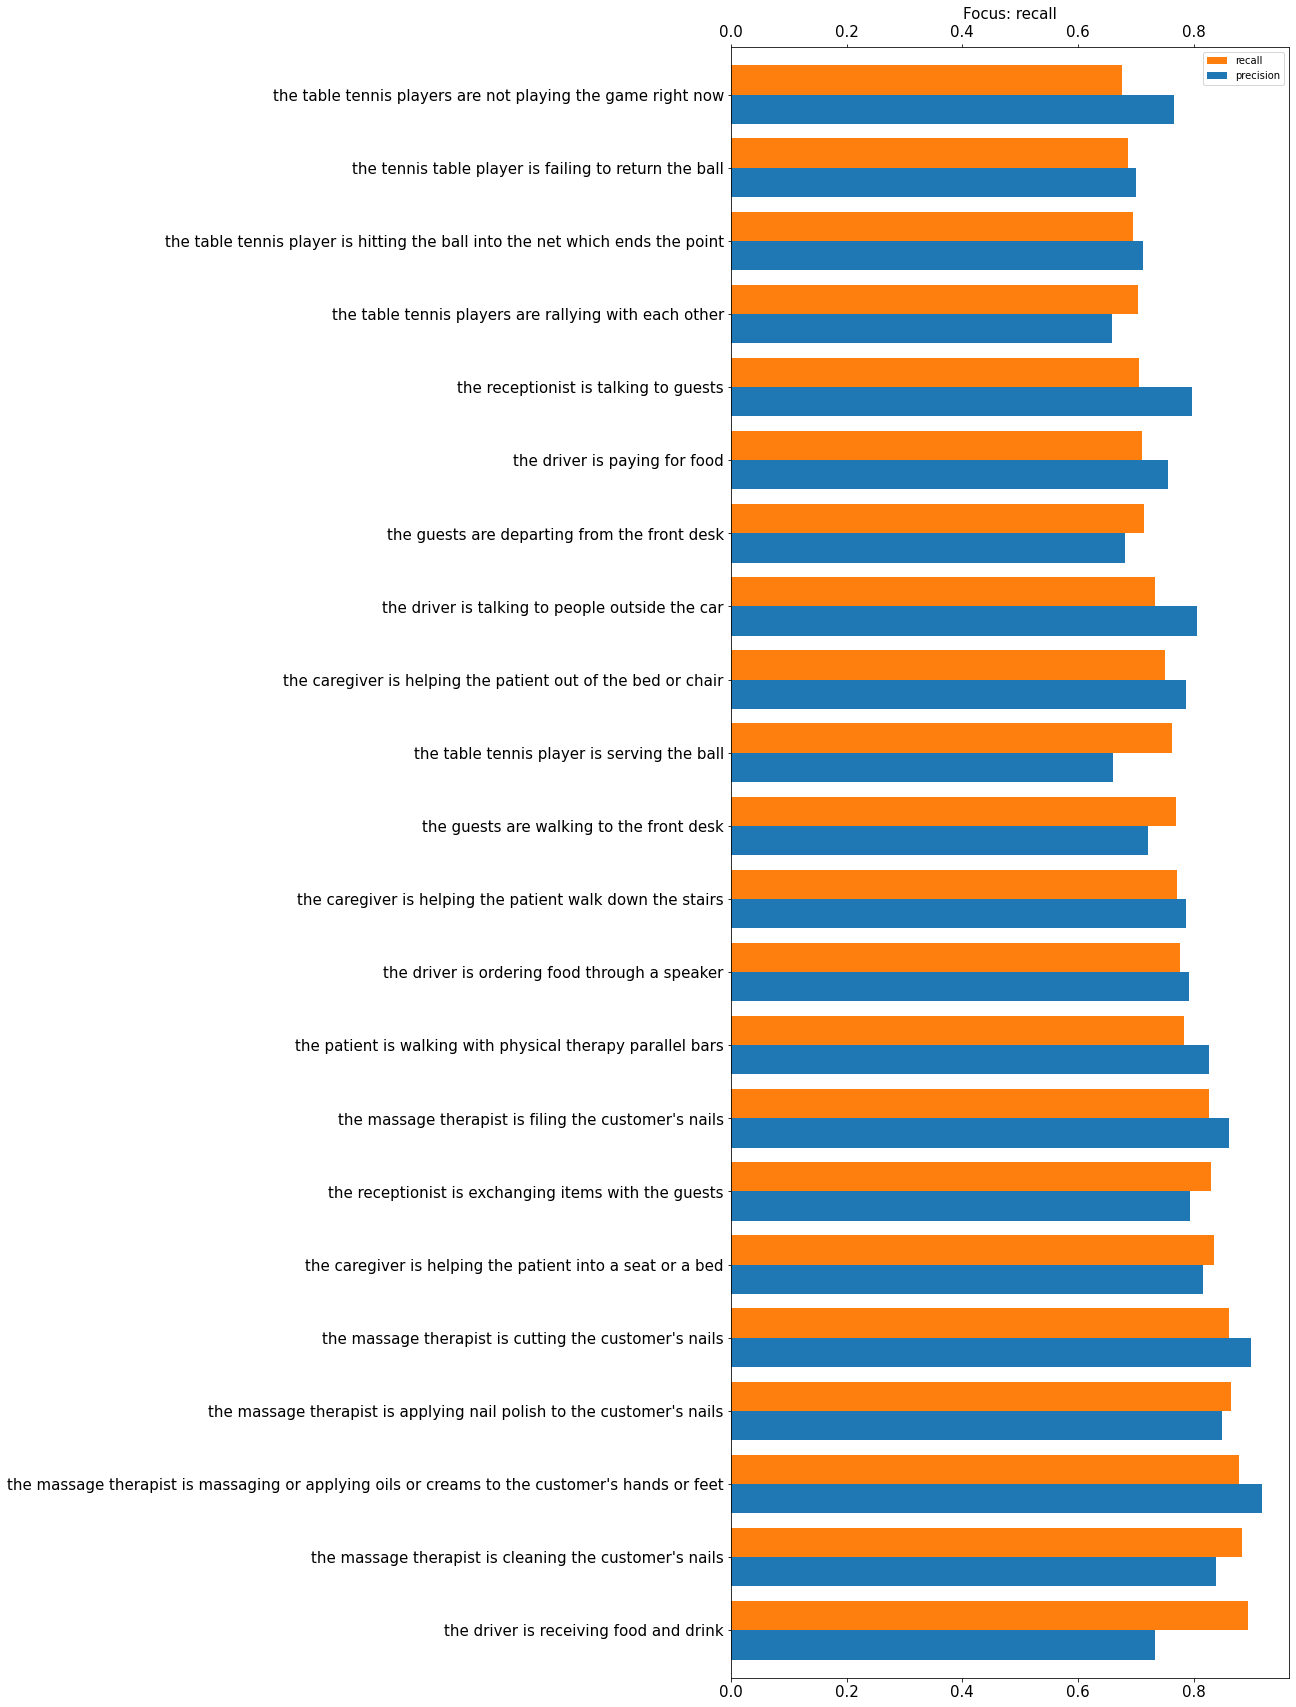

In [18]:
# Plot a bar chart for each stat in sorted order
MAX_COLS = 1
fig, axs = plt.subplots(ncols = len(stat_cols[:MAX_COLS]), figsize=(10 * len(stat_cols[:MAX_COLS]), 30), squeeze=False)

for i, col in enumerate(stat_cols[:MAX_COLS]):
    axs[0, i].tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
    axs[0, i].set_title(f"Focus: {col}", fontdict={"fontsize": 15})
    
    reordered_cols = [other_col for other_col in stat_cols if other_col != col] + [col] # So focused col is at the top
    results.sort_values(col, ascending=False)[reordered_cols].plot.barh(ax=axs[0, i], legend="reverse", fontsize=15, width=0.8)
    
plt.subplots_adjust(wspace=0.6)
plt.savefig(os.path.join(RESULTS_FOLDER, "error_rates.jpg"), bbox_inches="tight")
plt.show()